<a href="https://colab.research.google.com/github/HkgCory/Tensorflow-deeplearning-colab-dog_breed/blob/main/dog_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [8]:
# !unzip '/content/drive/MyDrive/deepLearning-dog/dog-breed-identification.zip' -d '/content/drive/MyDrive/deepLearning-dog/'

# end to end multiclass dog breed classification

This notebook builds an end to end multi class image classification using tensorflow 2.0 and tensorflow hub

#1 problem
identifying the breed of a dog given an image of a dog.

When Im sitting at the ccafe and i take a photo of a dog, I want to know what breed of a dog it is

#2 data.

The data we're using is from Kaggle's dog breed identification competition. 

# 3. Evaluation

The evaluation is a file with prediction probabilities for each dog breed of each test images.

#4. features

some information about the data:

we'r dealing with images(unstructured data) so it's probably best we use deep learning / transfer learning. 

there are 120 breeds of dogs, this means there are 120 different classes.

There are around 10000+ images in the training set.(these images have labels)

There are around 10000+ images in the test set( these images have no labels, because we will want to predict them.


#Get our workspace ready



In [9]:
import tensorflow as tf
print('TF version: ', tf.__version__)
import tensorflow_hub as hub
print('TF Hubversion: ', hub.__version__)
# check for gpu
print('gpu', 'available (yes!)' if tf.config.list_physical_devices('GPU') else 'not available')

TF version:  2.11.0
TF Hubversion:  0.12.0
gpu available (yes!)


# Get our Data Ready

With all machine learning models, our data has to be innumerical format. so we will have to convert the data first, turning the images into tensors (numerical representation). command m h to open keyboard preferences.

In [10]:
# checkout labels of our data

labels_csv = pd.read_csv('/content/drive/MyDrive/deepLearning-dog/labels.csv')
print(labels_csv.describe())
print(labels_csv.head())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     000bec180eb18c7604dcecc8fe0dba07  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<AxesSubplot:>

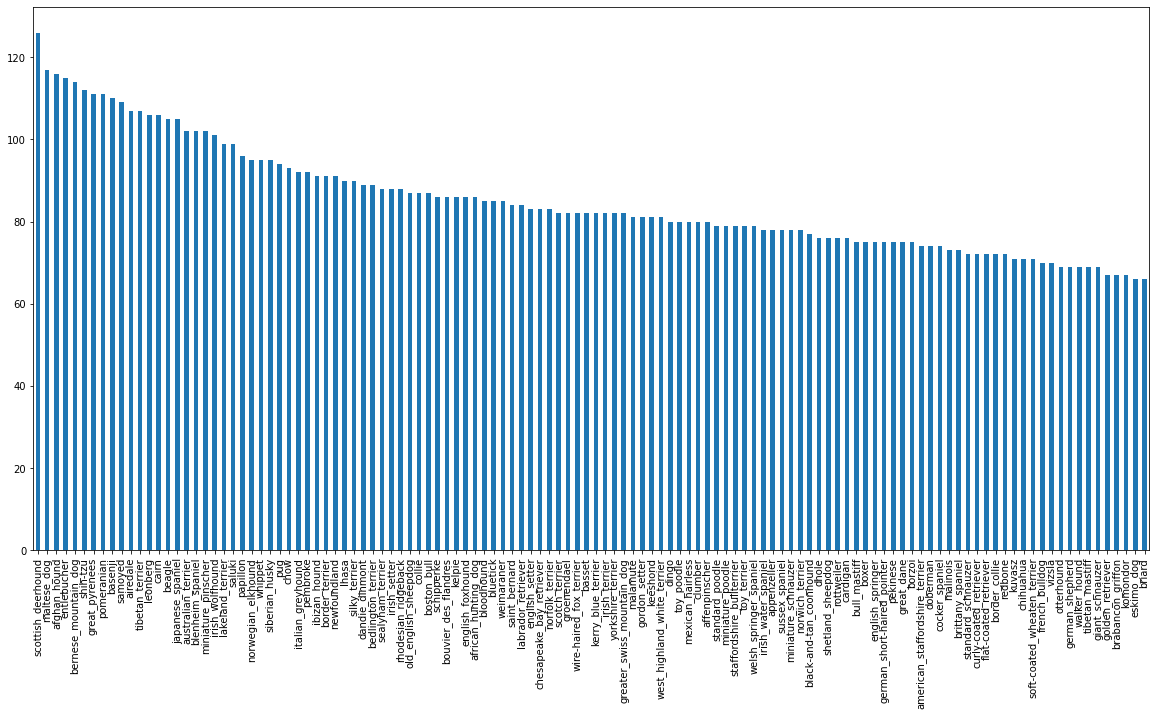

In [12]:
#how many images are there oof each breed?

labels_csv['breed'].value_counts().plot.bar(figsize=(20,10))

In [13]:
labels_csv['breed'].value_counts().median()

82.0

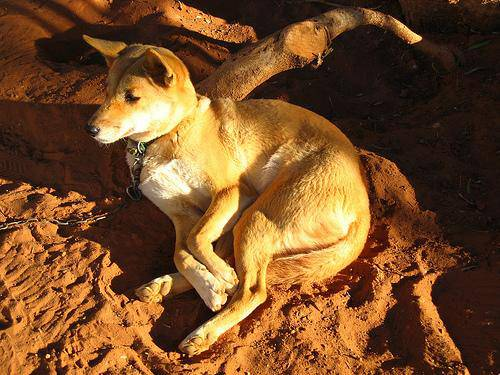

In [14]:
# view image
from IPython.display import Image
Image('/content/drive/MyDrive/deepLearning-dog/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg')

### Getting images and their labels

lets get a list of all our image file pathname


In [15]:
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [16]:
# create pathnames from image ID
filenames = ['/content/drive/MyDrive/deepLearning-dog/train/' + fname + '.jpg'for fname in labels_csv['id']]
filenames[:10]

['/content/drive/MyDrive/deepLearning-dog/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 '/content/drive/MyDrive/deepLearning-dog/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 '/content/drive/MyDrive/deepLearning-dog/train/001cdf01b096e06d78e9e5112d419397.jpg',
 '/content/drive/MyDrive/deepLearning-dog/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 '/content/drive/MyDrive/deepLearning-dog/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 '/content/drive/MyDrive/deepLearning-dog/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 '/content/drive/MyDrive/deepLearning-dog/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 '/content/drive/MyDrive/deepLearning-dog/train/002a283a315af96eaea0e28e7163b21b.jpg',
 '/content/drive/MyDrive/deepLearning-dog/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 '/content/drive/MyDrive/deepLearning-dog/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [17]:
# check whether number of filenames amtches number of actual image files

import os
if len(os.listdir('/content/drive/MyDrive/deepLearning-dog/train')) == len(filenames):
  print('Filenames match actual amount of files!!! Proceed.')
else:
  print('Filenames do not match actual amount of files, check the target directory.')

Filenames match actual amount of files!!! Proceed.


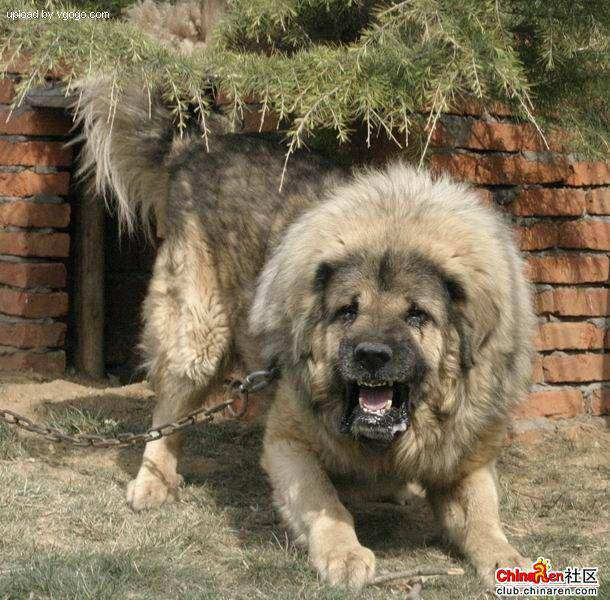

In [77]:
Image(filenames[9000])

In [19]:
labels_csv['breed'][9000]

'tibetan_mastiff'

now we have our training image filepath in a list, lets prepare labels


In [20]:
labels = np.array(labels_csv['breed'])
labels


array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [21]:
len(labels)

10222

In [22]:
#see if number of labels matches the nu,ber of filenames
if len(labels) == len(filenames):
  print('Number of labels amtches number of filenames!')
else:
  print('it doesnt match')

Number of labels amtches number of filenames!


In [23]:
#find the unique label value
unique_breeds = np.unique(labels)
len(unique_breeds)

120

In [24]:
#Turn a single label into an array of booleans
print(labels[0])
labels[0] == unique_breeds

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [25]:
#turn every label into a boolean array
boolean_labels = [label == unique_breeds for label in labels]
boolean_labels

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [26]:
len(boolean_labels)

10222

In [27]:
# example: turning boolean array into integers

print(labels[0])
print(np.where(unique_breeds == labels[0]))
print(boolean_labels[0].argmax())
print(boolean_labels[0].astype(int))

boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


#Creating our own validation set

Since the dataset from kaggle doesnt include validation set, we are going to create our own validation set.

In [28]:
# Setup X & y variables
X = filenames
y = boolean_labels

In [29]:
len(filenames)

10222

In [30]:
#We're going to start off experimenting with 1000 iamges and increase as needed.


In [31]:
# set number of images to use for experimenting 
NUM_IMAGES = 1000  #@param {type:'slider', min:1000, max:10000, steps:1000}

In [32]:
#lets split our data into train and validation sets

from sklearn.model_selection import train_test_split
# split them into training and validation of total size NUM_IMAGES

X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES],
                                                  y[:NUM_IMAGES],
                                                  test_size=0.2,
                                                  random_state=42)

len(X_train), len(y_train), len(X_val), len(y_val)

(800, 800, 200, 200)

In [33]:
# let's have a geez at the training data
X_train[:5], y_train[:2]

(['/content/drive/MyDrive/deepLearning-dog/train/00bee065dcec471f26394855c5c2f3de.jpg',
  '/content/drive/MyDrive/deepLearning-dog/train/0d2f9e12a2611d911d91a339074c8154.jpg',
  '/content/drive/MyDrive/deepLearning-dog/train/1108e48ce3e2d7d7fb527ae6e40ab486.jpg',
  '/content/drive/MyDrive/deepLearning-dog/train/0dc3196b4213a2733d7f4bdcd41699d3.jpg',
  '/content/drive/MyDrive/deepLearning-dog/train/146fbfac6b5b1f0de83a5d0c1b473377.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, Fals

#Preprocessing Images (turning images into Tensors)

To preprocess our images into tensors we are going to write a function which does a few things:

1. take an image filepath as input
2. use tensorflow to read the file and save it to a variable, `image`
3. Turn our `image` (a jpg) into Tensors
4. Normalize our image (convert color channel values from 0-255 to 0-1).
5. Resize the `image` to be a shape of(224, 224)
6. Return the modified `image`

In [34]:
# convert image to numpy array 

from matplotlib.pyplot import imread
image = imread(filenames[42])
image.shape

(257, 350, 3)

In [35]:
image.max(), image.min()

(255, 0)

In [36]:
#turn images into tensors
tf.constant(image)[:3]


<tf.Tensor: shape=(3, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]],

       [[ 56, 104,  66],
        [ 58, 106,  66],
        [ 64, 112,  72],
        ...,
        [ 71, 127,  82],
        [ 73, 129,  84],
        [ 73, 130,  85]]], dtype=uint8)>

In [37]:
tf.constant(imread(filenames[9000]))[:2]

<tf.Tensor: shape=(2, 610, 3), dtype=uint8, numpy=
array([[[124, 129,  88],
        [150, 155, 114],
        [122, 127,  86],
        ...,
        [ 80,  85,  55],
        [ 66,  73,  40],
        [ 66,  73,  40]],

       [[144, 149, 108],
        [153, 158, 117],
        [121, 126,  85],
        ...,
        [ 58,  63,  33],
        [ 65,  72,  39],
        [ 65,  72,  39]]], dtype=uint8)>

In [38]:
#define img size
IMG_SIZE  = 224
#create a function for preprocessing images

def process_image(image_path, img_size = IMG_SIZE):

  #take an image file path and turns the image into a tensor

#read an image file
  image = tf.io.read_file(image_path)
# turn the image into numerical tensor with 3 color channels (RGB)
  image = tf.image.decode_jpeg(image, channels = 3)
# Convert the color channel values from 0-255 to 0-1 value
  image = tf.image.convert_image_dtype(image, tf.float32)
# Resize the iamge to our desired value (224, 224)
  image = tf.image.resize(image, size = [IMG_SIZE, IMG_SIZE])

  return image

In [39]:
tensor = tf.io.read_file(filenames[26])
tensor

<tf.Tensor: shape=(), dtype=string, numpy=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\n\x07\x07\x08\x07\x06\n\x08\x08\x08\x0b\n\n\x0b\x0e\x18\x10\x0e\r\r\x0e\x1d\x15\x16\x11\x18#\x1f%$"\x1f"!&+7/&)4)!"0A149;>>>%.DIC<H7=>;\xff\xdb\x00C\x01\n\x0b\x0b\x0e\r\x0e\x1c\x10\x10\x1c;("(;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;\xff\xc0\x00\x11\x08\x01\xf4\x01w\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1f\x00\x00\x01\x05\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\xff\xc4\x00\xb5\x10\x00\x02\x01\x03\x03\x02\x04\x03\x05\x05\x04\x04\x00\x00\x01}\x01\x02\x03\x00\x04\x11\x05\x12!1A\x06\x13Qa\x07"q\x142\x81\x91\xa1\x08#B\xb1\xc1\x15R\xd1\xf0$3br\x82\t\n\x16\x17\x18\x19\x1a%&\'()*456789:CDEFGHIJSTUVWXYZcdefghijstuvwxyz\x83\x84\x85\x86\x87\x88\x89\x8a\x92\x93\x94\x95\x96\x97\x98\x99\x9a\xa2\xa3\xa4\xa5\xa6\xa7\xa8\xa9\xaa\xb2\xb3\xb4\xb5\xb6\xb7\xb8\xb9\xba\xc2\xc3\xc4\xc5\xc6\xc7\xc8\xc9\xca

In [44]:
tf.image.decode_jpeg(tensor, channels = 3)

<tf.Tensor: shape=(500, 375, 3), dtype=uint8, numpy=
array([[[ 59,  68,  65],
        [ 64,  73,  70],
        [ 71,  80,  77],
        ...,
        [115, 128, 108],
        [115, 128, 108],
        [110, 123, 103]],

       [[ 65,  74,  71],
        [ 72,  81,  78],
        [ 79,  88,  85],
        ...,
        [114, 127, 107],
        [117, 130, 110],
        [116, 129, 109]],

       [[ 68,  77,  74],
        [ 76,  85,  82],
        [ 83,  92,  89],
        ...,
        [114, 127, 107],
        [120, 133, 113],
        [123, 136, 116]],

       ...,

       [[173, 200, 155],
        [164, 179, 136],
        [181, 166, 133],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[142, 159, 117],
        [147, 154, 113],
        [189, 174, 141],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[167, 179, 139],
        [167, 172, 132],
        [204, 188, 155],
        ...,
        [255, 255, 25

## Turning our data into batches

Why turn our data into batches???



let's say you're trying to process 10k+ images in one go... they all might not fit into memory.

So that's why we do about 32 (this is batch size) images at a time ( you can manually adjust the batch size if need to be)

In order to use TensorFlow effectively, we need our data in the form of Tensor tuples which look like this:
`(image, label).



In [46]:
# create a simple function to return a tuple (image, label)
def get_image_label(image_path, label):
  """
    Takes an image file path name and the associated label,
    processes the image and returns a tuple of (image,label).
  """
  image = process_image(image_path)
  return image,label

In [43]:
# demo of the above
(process_image(X[42],y[42]))[:2]

<tf.Tensor: shape=(2, 224, 3), dtype=float32, numpy=
array([[[0.3264178 , 0.5222886 , 0.3232816 ],
        [0.2537167 , 0.44366494, 0.24117757],
        [0.25699762, 0.4467087 , 0.23893751],
        ...,
        [0.29325107, 0.5189916 , 0.3215547 ],
        [0.29721776, 0.52466875, 0.33030328],
        [0.2948505 , 0.5223015 , 0.33406618]],

       [[0.25903144, 0.4537807 , 0.27294815],
        [0.24375686, 0.4407019 , 0.2554778 ],
        [0.2838985 , 0.47213382, 0.28298813],
        ...,
        [0.2785345 , 0.5027992 , 0.31004712],
        [0.28428748, 0.5108719 , 0.32523635],
        [0.28821915, 0.5148036 , 0.32916805]]], dtype=float32)>

Now we've got a way to turn our data into tuples of Tensors in the form: `(image,label)`, let's make a function to turn all of our data (X & y) into batches

In [80]:
#define the batch size, 32 is a good start

BATCH_SIZE = 32

#create a function to turn data into batches

def create_data_batches(X,y=None, batch_size=BATCH_SIZE, valid_data = False, test_data=False):
  """
  Creates batches of data out of image(X) and label (y) pairs.
  Shuffles the data if its training data but doesnt shuffle if its validation data.
  Also accepts test data as input (no labels).
    """

    # If the data is a test dataset, we probably don't have labels
  if test_data:
    print('Creating test data batches...')
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X))) #only filepaths (no labels)
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

    #if the data is a valid dataset, we dont need to shuffle it 

  elif valid_data:
    print('Creating validation data batches...')
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y)))
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

  else:
    print('Creating training data batches')
    # turn filepaths and labels into tensors

    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),tf.constant(y)))

    # shuffling pathnames and labels before mapping image processor function is faster than shuffling
    data = data.shuffle(buffer_size = len(X))
    #create (image, label)tuples (this also turns the image path into a preprocess image)
    data = data.map(get_image_label)
    #Turn the training data into batches
    data_batch = data.batch(BATCH_SIZE)

  return data_batch











In [81]:
# Create training and validation data batches
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)

Creating training data batches
Creating validation data batches...


In [82]:
#Checking out the different attributes of our data batches
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

In [71]:
y[0]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

## Visualizing data batches

our data is now in batches, however, these can be a little hard to understand/comprehend, let's visualize the data batch

In [111]:
import matplotlib.pyplot as plt

# Create a function for viewing images in a data batch
def show_25_images(images, labels):
  """
  Displays a plot of 25 iamges and their labels from a data batch.
  """

  #setup the figure
  plt.figure(figsize=(10,10))
  #loop through 25(for displaying 25 images)
  for i in range(25):
    #Create subplots (5 rows, 5 columns)
    ax = plt.subplot(5,5, i+1)
    #Display an image
    plt.imshow(images[i])
    # Add the iamge label as the title
    plt.title(unique_breeds[labels[i].argmax()])
    # Turn the grid lines off
    plt.axis('off')

In [54]:
train_data

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

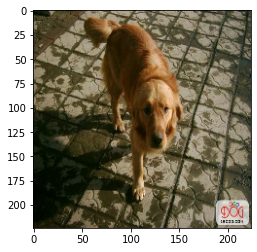

In [106]:
plt.imshow(train_images[0])

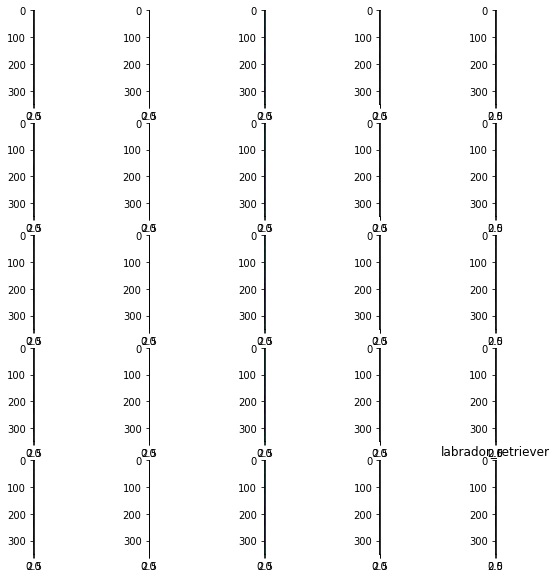

In [96]:
train_images, train_labels = next(train_data.as_numpy_iterator())
show_25_images(train_images, train_labels)

In [53]:
unique_breeds[y[0].argmax()]

'boston_bull'

In [105]:
unique_breeds[train_labels[5].argmax()]

'norfolk_terrier'

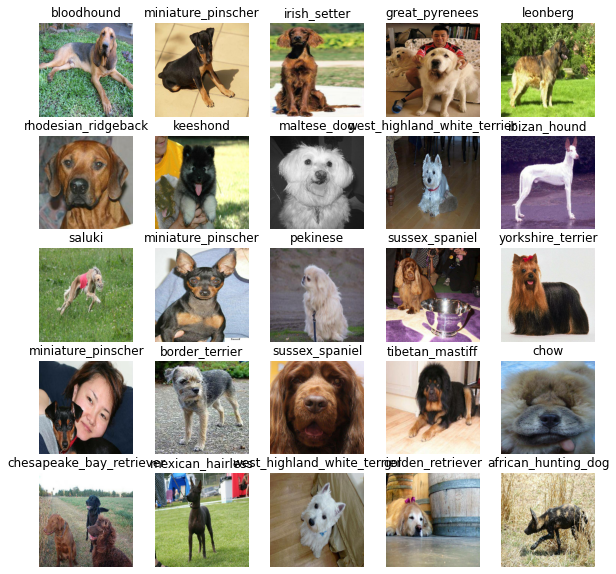

In [112]:
# Now let's visualize the data in a training batch
train_images, train_labels = next(train_data.as_numpy_iterator())
show_25_images(train_images, train_labels)

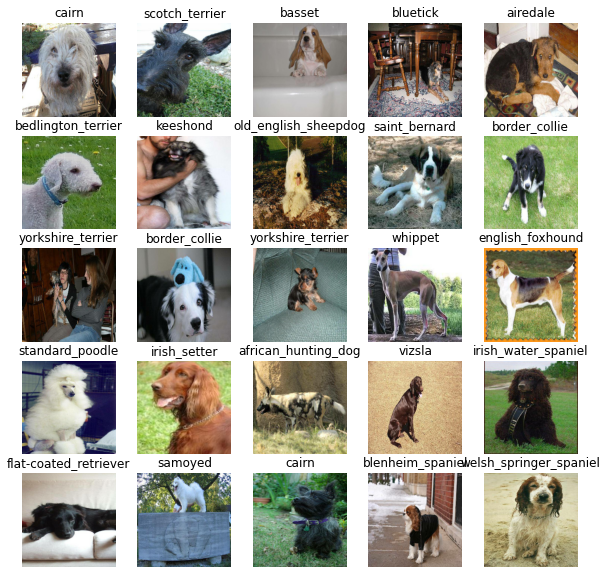

In [115]:
# Now let's visualize our validation set
val_images, val_labels = next(val_data.as_numpy_iterator())
show_25_images(val_images, val_labels)

# building a model

before we build a model, there are a few things we need to define:
* the input shape (our images shape, in the form of Tensors) to our model.
* The output shape (image labels, in the form of Tensors) of our model
* The URL of the model we want to use

In [ ]:
# Setup input shape to the model

INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] #batch, height, width, color channels

# setup output shape of our model
OUTPUT_SHAPE = len(unique_breeds)

# setup model URL from TensorFlow Hub

MODEL_URL = 